In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib

%load_ext autoreload
%reload_ext autoreload

In [2]:
import simulation
import controller
from simulation import *
from main_bus import MainBus

Using TensorFlow backend.


In [3]:
importlib.reload(simulation)
importlib.reload(controller)

<module 'controller' from '/home/marco/Documents/UvA/MAS/multi-agent-systems/Project/Python/controller.py'>

### Initialization

In [4]:
# Parameters

replay_length = 10000
iterations = 1440 # num of ticks per epoch
epochs = 10 # num of times network is unfrozen, trained
batch_size_ratio = 0.5 # num of samples from replay memory to train on
animate = False
add_arrivals_noise = False

# Model
loggers = []
simulation = Simulation(MainBus, loggers=loggers)
replay_memory = deque(maxlen = replay_length)
training_results = []
training_loss = []

Initializing Prob Dist


### Training

In [12]:
# Main training loop
epochs = 50
for epoch in range(epochs):
    print('Epoch #%d' % (epoch+1))
    
    simulation.reset(add_arrivals_noise) # resets everything
    
    training_results.append(simulation.execute(iterations=iterations)) # simulate and collect logs
    training_loss.append(simulation.controller.get_total_cost()) # collect loss

    replay_memory.extend(simulation.controller.replay_memory) # store data into replay memory
    
    # Get random samples
    training_idx = np.random.choice(len(replay_memory), size = np.int(len(replay_memory) * batch_size_ratio))
    training_samples = [replay_memory[i] for i in training_idx]

    # Train DQN
    simulation.controller.destination_model.train(training_samples)
    


Epoch #1
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 69399.6250
Epoch #2
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 73956.7344
Epoch #3
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 45050.9688
Epoch #4
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 27678.9434
Epoch #5
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 74677.5781
Epoch #6
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 53983.7812
Epoch #7
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 72008.6016
Epoch #8
 1440 / 1440 (5000, 649) (5000,)
Epoch 1/1
5000/5000 [==============================] - 0s - loss: 165250.6406
Epoch #9
 1440 / 1440 (5000, 649) (5000,)
Epoch

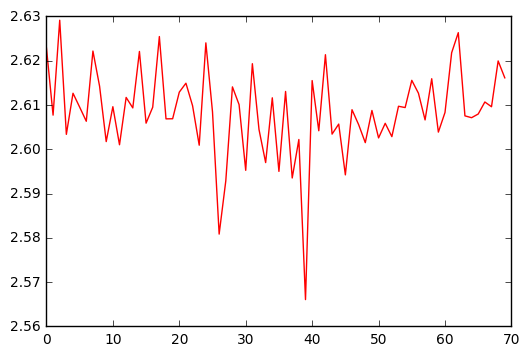

In [13]:
plt.plot(training_loss, 'r-')
plt.show()

In [14]:
simulation.reset()
simulation.execute(iterations=100, animate=True)

{}

In [15]:
HTML(simulation.anim.to_html5_video())